Let's install and import some stuff first:

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch torchvision torchaudio

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
import pandas as pd
import numpy as np

import random
import os
from urllib import request
import tensorflow

import torch
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer


import scipy.stats as ss

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Load Don't Patronize Me Module and Scorer (we only have to do this once)

In [3]:
'''module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))
  
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))'''

'module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"\nmodule_name = module_url.split(\'/\')[-1]\nprint(f\'Fetching {module_url}\')\n#with open("file_1.txt") as f1, open("file_2.txt") as f2\nwith request.urlopen(module_url) as f, open(module_name,\'w\') as outf:\n  a = f.read()\n  outf.write(a.decode(\'utf-8\'))'

Now we can read in the dataset. Since right now, we only want to be able to classify our synthetic data, we will balance our dataset by downsampling the nontoxic data. We store train and test data in csv-files for later use (esp. for comparibility). Again, we only have to do this once. Once we have saved the data, we can skip this cell

In [5]:
'''from dont_patronize_me import DontPatronizeMe

dpm = DontPatronizeMe('.', 'dontpatronizeme_pcl.tsv')
dpm.load_task1()
dpm.train_task1_df.head()

df_nontoxic = dpm.train_task1_df[dpm.train_task1_df["label"] == 0]
df_toxic = dpm.train_task1_df[dpm.train_task1_df["label"] == 1]

df_nontoxic_downsampled = df_nontoxic.sample(df_toxic.shape[0])

dpm_balanced = pd.concat([df_toxic, df_nontoxic_downsampled])

X = dpm_balanced["text"].values.tolist()
y = dpm_balanced["label"].values.tolist()

# Let's split the dataset into train and test data. We will store both for later use.
train_text, test_text, train_labels, test_labels = train_test_split(X, y, random_state=42, test_size=.1, stratify=y)

train_data = pd.DataFrame({"text": train_text, "label": train_labels})
test_data = pd.DataFrame({"text": test_text, "label": test_labels})

test_data.to_csv("test_data_downsampled.csv")
train_data.to_csv("train_data_downsampled.csv")'''

If we have already created the csv-files, we can read them in here

In [ ]:
train_data = pd.read_csv("train_data_downsampled.csv")
test_data = pd.read_csv("test_data_downsampled.csv")

train_text = train_data["text"].values.tolist()
train_labels = train_data["labels"].values.tolist()

test_text = test_data["text"].values.tolist()
test_labels = test_data["labels"].values.tolist()

In [19]:
# splitting the training set further into training and validation data. We will use this data for finetuning
train_text, val_text, train_labels, val_labels = train_test_split(train_text, train_labels, random_state=42,
                                                                  test_size=.1, stratify=train_labels)

In [20]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', max_length=512)

In [22]:
# Tokenizing our data
encoded_train = tokenizer(train_text, truncation=True, padding=True)
encoded_val = tokenizer(val_text, truncation=True, padding=True)
encoded_test = tokenizer(test_text, truncation=True, padding=True)

In [24]:
# creating a function for mapping encoded data to labels
class dpm_dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [25]:
train_set = dpm_dataset(encoded_train, train_labels)
val_set = dpm_dataset(encoded_val, val_labels)
test_set = dpm_dataset(encoded_test, test_labels)

If we have trained and saved the model before, we can load it here (2nd line)

In [26]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
#model = AutoModelForSequenceClassification.from_pretrained('semeval_task4/model_downsampled', num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Defining metrics our trainer uses in evaluation steps

In [27]:
def compute_metrics(pred):
    logits, labels = pred
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

In [28]:
training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch")

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    compute_metrics=compute_metrics,
)

Let's fine-tune!

In [30]:
trainer.train()

***** Running training *****
  Num examples = 1608
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 603


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.432008,0.810056,0.797619,0.858974,0.744444
2,No log,0.490392,0.849162,0.862944,0.794393,0.944444
3,0.390900,0.643342,0.826816,0.839378,0.786408,0.900000


***** Running Evaluation *****
  Num examples = 179
  Batch size = 8
***** Running Evaluation *****
  Num examples = 179
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 179
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=603, training_loss=0.3472985968265565, metrics={'train_runtime': 214.4514, 'train_samples_per_second': 22.495, 'train_steps_per_second': 2.812, 'total_flos': 1269247731056640.0, 'train_loss': 0.3472985968265565, 'epoch': 3.0})

And check how our model performs on our test data:

In [ ]:
#redefining compute_metrics function to fit trainer.predict returns
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

y_pred = trainer.predict(test_set)

In [39]:
compute_metrics(y_pred)

{'accuracy': 0.8492462311557789,
 'f1': 0.8543689320388348,
 'precision': 0.822429906542056,
 'recall': 0.8888888888888888}

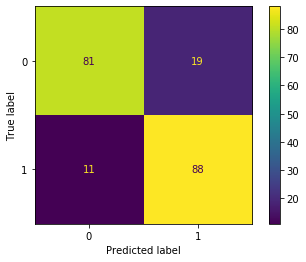

In [38]:
cm = confusion_matrix(y_pred.label_ids, y_pred.predictions.argmax(-1))
ConfusionMatrixDisplay.from_predictions(y_pred.label_ids, y_pred.predictions.argmax(-1))

Looking pretty good. We can save the model here for later use.

In [35]:
#trainer.save_model('semeval_task4/model_downsampled')

Saving model checkpoint to semeval_task4/model_downsampled
Configuration saved in semeval_task4/model_downsampled/config.json
Model weights saved in semeval_task4/model_downsampled/pytorch_model.bin


In [ ]:
def labels2file(p, outf_path):
    with open(outf_path,'w') as outf:
        for pi in p:
            outf.write(','.join([str(k) for k in pi])+'\n')
            
!mkdir ref res